In [ ]:
!pip install livelossplot
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 17kB/s 
     |████████████████████████████████| 450kB 40.0MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 3.9MB 18.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=989a716159ece653d0bcee8383d9d821ad92764fac39b548cadc781b6e2471b1
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
cp 'Selected.zip' '/content'

In [ ]:
cp 'segmenter_weights.h5' '/content'

In [ ]:
cd '/content'

/content


In [ ]:
!unzip Selected.zip

Archive:  Selected.zip
   creating: SelectedSGTs/
  inflating: SelectedSGTs/Sp_D_CRN_A_ani0036_ani0066_0372_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_ani0028_pla0007_0284_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_arc0096_cha0025_0490_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_art0088_art0092_0108_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_pla0085_cha0043_0495_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0031_ani0100_0432_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_ani0081_ani0088_0430_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0079_ani0065_0420_gt.png  
  inflating: SelectedSGTs/Sp_D_CNN_A_sec0012_ani0007_0275_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_arc0078_arc0064_0106_gt.png  
  inflating: SelectedSGTs/Sp_D_CRN_A_art0042_sec0086_0379_gt.png  
  inflating: SelectedSGTs/Sp_D_CNN_A_ani0049_ani0084_0266_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0036_art0053_0473_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_sec0021_cha0086_0502_gt.png  
  inflating:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
import os
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [ ]:
ls

gdrive/  sample_data/  SelectedSGTs/  SelectedSpliced/  Selected.zip


In [ ]:
import os
from PIL import Image, ImageOps

splicedGT=os.listdir('SelectedSGTs')
splicedIMG=os.listdir('SelectedSpliced')

In [ ]:
mkdir SGTResized

In [ ]:
mkdir SplicedResized

In [ ]:
mkdir ELAs

In [ ]:
ls

ELAs/    sample_data/   SelectedSpliced/  SGTResized/
gdrive/  SelectedSGTs/  Selected.zip      SplicedResized/


In [ ]:
#rm -r 'SplicedResized' 'SGTResized'

#### ELA - Mask

In [ ]:
for i in splicedGT:
  ImageOps.grayscale(Image.open('SelectedSGTs/'+str(i)).resize((256,256))).save('SGTResized/'+str(i))
  
for i in splicedIMG:
  convert_to_ela_image('SelectedSpliced/'+str(i), 90).resize((256,256)).save('ELAs/'+str(i))

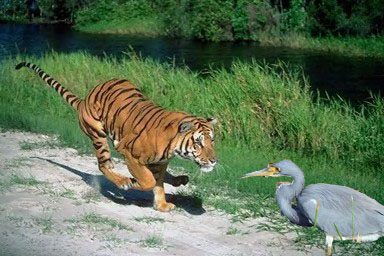

In [ ]:
Image.open('SelectedSpliced/Sp_D_CRN_A_ani0036_ani0066_0372.jpg')

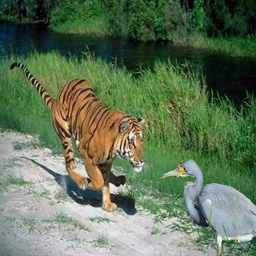

In [ ]:
Image.open('SelectedSpliced/Sp_D_CRN_A_ani0036_ani0066_0372.jpg').resize((256,256))

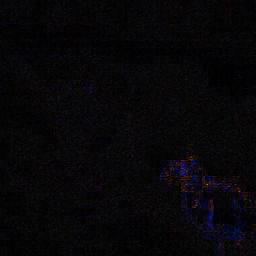

In [ ]:
Image.open('ELAs/Sp_D_CRN_A_ani0036_ani0066_0372.jpg')

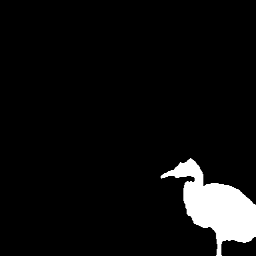

In [ ]:
Image.open('SGTResized/Sp_D_CRN_A_ani0036_ani0066_0372_gt.png')

### Data Prep

In [ ]:
X = []
Y = []

#### ELA Threshold - Mask

In [ ]:
def thresholdMask(img):
    imgarr=np.array(img.getchannel('B'))
    thres=40
    arr=[[0]*256]*256
    masked=np.array(arr)
    for i in range(256):
        for j in range(256):
            if imgarr[i][j]>thres:
                masked[i][j]=1
    threshimg=Image.fromarray((masked*255).astype('uint8'))
    return threshimg

In [ ]:
for i in splicedIMG:
  X.append(np.array(thresholdMask(Image.open('ELAs/'+str(i))))/255.0)

for i in splicedGT:
  Y.append(np.array(Image.open('SGTResized/'+str(i)))/255.0)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(209, 256, 256)

In [ ]:
X = X.reshape(-1, 256,256, 1)
Y = Y.reshape(-1, 256,256, 1)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [ ]:
X_train.shape

(167, 256, 256, 1)

In [ ]:
X_val.shape

(42, 256, 256, 1)

###Segmenter

In [ ]:
inputs = Input((256,256,1))
conv1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6])
conv6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7])
conv7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8])
conv8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9])
conv9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

model.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_62 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_63 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
model.compile(optimizer = Adam(lr=0.0001) , loss = "binary_crossentropy", metrics=["binary_accuracy"])

In [ ]:
model_checkpoint = ModelCheckpoint('segmenter_weights.h5', monitor='val_accuracy',verbose=1, save_best_only=True)

In [ ]:
model.fit(X, Y, batch_size=4, epochs=200, verbose=1,validation_split=0.2, shuffle=True, callbacks=[PlotLossesCallback(),model_checkpoint])

KeyboardInterrupt: ignored

In [ ]:
cp 'segmenter_weights.h5' '/content/gdrive/My Drive/Colab Notebooks/segmenter_weights.h5'

### Testing

In [ ]:
test=np.array(convert_to_ela_image('SelectedSpliced/Sp_D_CRN_A_ani0036_ani0066_0372.jpg', 90).resize((256,256))) / 255.0

In [ ]:
n=11

In [ ]:
test=X[n]*255

In [ ]:
testGT=Y[n].reshape(256,256)

In [ ]:
test=test.reshape(-1,256,256,1)

In [ ]:
result=model.predict(test)

In [ ]:
result=result.reshape(256,256)

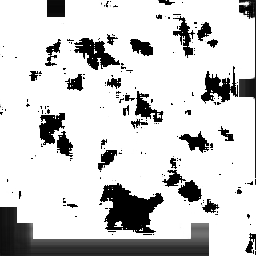

In [ ]:
Image.fromarray((result*255).astype('uint8'))

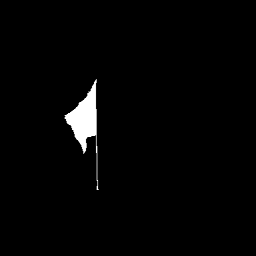

In [ ]:
Image.fromarray((testGT*255).astype('uint8'))